In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from data_loader import load_track_data, load_race_data
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
import geopandas as gpd


In [60]:
track_left_side, track_right_side = load_track_data(distance_pr_dot = 10)
track_left_side

c:\GitHub\RacingTrajectories\data_loader.py:5: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  track_left_side = pd.read_csv(f'Data/Map_details/nurburgring_GP_track_leftside_raw.csv', index_col=False)
c:\GitHub\RacingTrajectories\data_loader.py:6: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  track_right_side = pd.read_csv(f'Data/Map_details/nurburgring_GP_track_rightside_raw.csv', index_col=False)


,Timestamp,Y-Coords,Z-Coords,X-Coords
0,12.072,2.187290,63.983009,764.897095
281,1.647,2.466815,63.926163,754.858582
373,3.078,2.453801,63.868355,744.798401
445,4.200,2.358396,63.816849,734.727173
508,5.190,2.266824,63.755978,724.561401
...,...,...,...,...
27068,420.057,2.522225,64.043800,777.787354
27109,420.696,2.447313,63.991814,767.740540
27152,0.321,2.421583,63.932785,757.701721
27212,1.260,2.485023,63.874542,747.589783


c:\GitHub\RacingTrajectories\data_loader.py:5: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  track_left_side = pd.read_csv(f'Data/Map_details/nurburgring_GP_track_leftside_raw.csv', index_col=False)
c:\GitHub\RacingTrajectories\data_loader.py:6: ParserWarning: Length of header or names does not match length of data. This leads to a loss of data with index_col=False.
  track_right_side = pd.read_csv(f'Data/Map_details/nurburgring_GP_track_rightside_raw.csv', index_col=False)


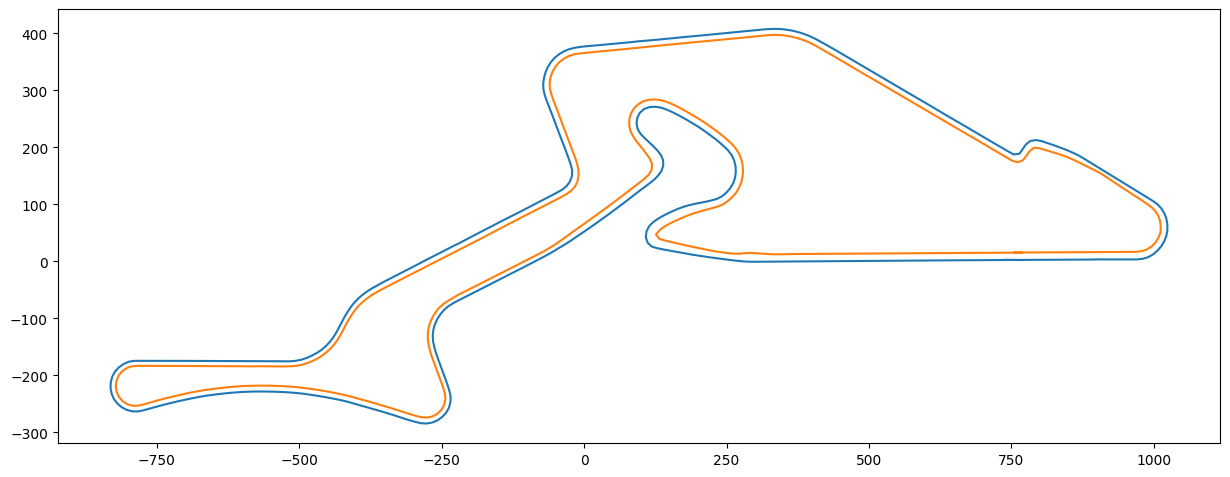

In [33]:
# Plot the reduced track in 2D using matplotlib
track_left_side, track_right_side = load_track_data(distance_pr_dot = 10)
fig, ax = plt.subplots()
ax.plot(track_left_side['X-Coords'],track_left_side['Y-Coords'])
ax.plot(track_right_side['X-Coords'],track_right_side['Y-Coords'] )
ax.set_aspect('equal')
fig.set_size_inches(15, 10)
plt.show()

In [25]:
# Import real left and right track data. from ./Data/Map_details/Left_boundary.csv and Right_boundary.csv
### NOTE ONLY RUN ONCE

for txt_file in ['Left_boundary', 'Right_boundary']:
    with open(f'./Data/Map_details/{txt_file}.txt', 'r') as f:
        # left_boundary = pd.read_csv(f)
        boundary = f.readlines()
        boundary = [x.split() for x in boundary][0]
        boundary = [x[:-2] for x in boundary]
        boundary = [x.split(',') for x in boundary]

        df_boundary = pd.DataFrame(boundary, columns = ['Longitude', 'Latitude'])
        # save to csv file
        df_boundary.to_csv(f'./Data/Map_details/{txt_file}.csv', index = False)


In [26]:
real_track_left_side  = pd.read_csv('./Data/Map_details/Left_boundary.csv')
real_track_right_side = pd.read_csv('./Data/Map_details/Right_boundary.csv')
real_track_right_side

,Longitude,Latitude
0,6.947242,50.335378
1,6.947557,50.335586
2,6.947965,50.335849
3,6.948183,50.335997
4,6.948543,50.336224
...,...,...
388,6.943929,50.333223
389,6.944191,50.333396
390,6.944691,50.333727
391,6.947055,50.335270


     X-Coords   Y-Coords
0    6.947900  50.335826
281  6.947803  50.335765
373  6.947709  50.335702
445  6.947614  50.335638
508  6.947519  50.335573
   Longitude   Latitude
0   6.945547  50.334080
1   6.945850  50.334280
2   6.946050  50.334407
3   6.946372  50.334618
4   6.946770  50.334880


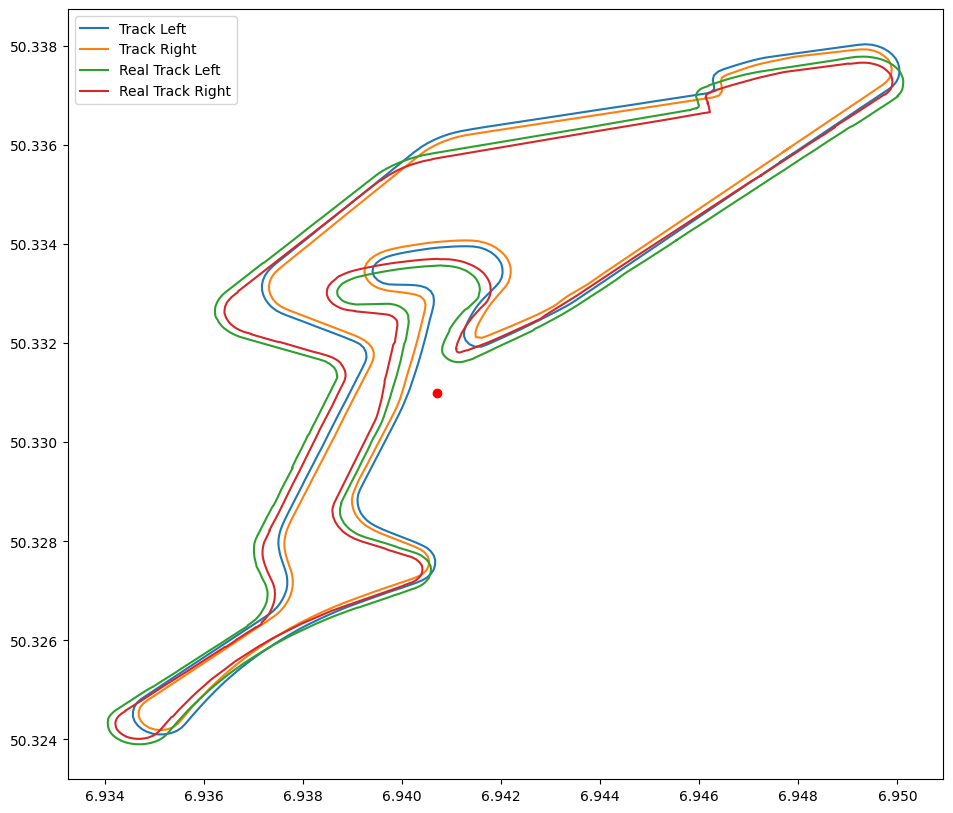

In [166]:
def transform_coordinates(original_df, rotation_angle, scale_x, scale_y, shift_x, shift_y, center_x, center_y):
    """
    Transforms coordinates by rotating, scaling, and shifting.

    Args:
    rotation_angle: rotation angle in degrees.
    scale_x, scale_y: scaling factors for the x and y axes.
    shift_x, shift_y: shifting values for the x and y axes.
    center_x, center_y: the center point around which rotation is performed.

    Returns:
    Transformed x and y coordinates as numpy arrays.
    """
    x = np.array(original_df['X-Coords'])
    y = np.array(original_df['Y-Coords'])

    angle_rad = np.radians(rotation_angle)
    rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                                [np.sin(angle_rad), np.cos(angle_rad)]])
    x_shifted, y_shifted = x - center_x, y - center_y
    original_points = np.vstack((x_shifted, y_shifted))
    rotated_points = np.dot(rotation_matrix, original_points)
    scaled_points = np.vstack((rotated_points[0] * scale_x, rotated_points[1] * scale_y))
    transformed_points = scaled_points + np.vstack((shift_x + center_x, shift_y + center_y))

    new_df = original_df.copy()
    new_df['X-Coords'] = transformed_points[0, :]
    new_df['Y-Coords'] = transformed_points[1, :]

    return new_df


def plot_track(track_left, track_right, real_track_left_side, real_track_right_side):

    fig, ax = plt.subplots()
    ax.plot(track_left['X-Coords'],track_left['Y-Coords'])
    ax.plot(track_right['X-Coords'],track_right['Y-Coords'] )
    ax.plot(real_track_left_side['Longitude'], real_track_left_side['Latitude'])
    ax.plot(real_track_right_side['Longitude'], real_track_right_side['Latitude'])
    ax.set_aspect('equal')

    # add a dot for the center of the track
    ax.plot(center_x + shift_x, center_y+ shift_y, 'ro')
    # ax.plot(6.940023,50.330995, 'go')

    plt.legend(['Track Left', 'Track Right', 'Real Track Left', 'Real Track Right'], loc='upper left')
    fig.set_size_inches(15, 10)
    plt.show()


rotation_angle = 42
scale_x = 0.0000127
scale_y = 0.0000094
shift_x = 6.9407
shift_y = 50.331
center_x = 0
center_y = 0

trans_track_left = transform_coordinates(track_left_side, rotation_angle, scale_x, scale_y, shift_x, shift_y, center_x, center_y)
trans_track_right = transform_coordinates(track_right_side, rotation_angle, scale_x, scale_y, shift_x, shift_y, center_x, center_y)

print(trans_track_left[["X-Coords", "Y-Coords"]].head()) 
print(real_track_left_side.head(5))

plot_track(track_left = trans_track_left, track_right = trans_track_right, 
            real_track_left_side = real_track_left_side, 
            real_track_right_side = real_track_right_side)



In [ ]:
# create a function which converts the dataframe to latitudinal and longitudinal coordinates

def convert_df_to_lat_long(left_df, right_df):
    # convert the dataframe to latitudinal and longitudinal coordinates

    # return geo_df

geo_df = convert_df_to_lat_long(df)

NameError: name 'geo_df' is not defined

In [ ]:

def summarize_graph(G):
    # Basic information
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    num_components = nx.number_connected_components(G)
    avg_degree = sum(dict(G.degree()).values()) / num_nodes
    
    # More detailed analysis
    components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
    largest_component = max(components, key=len)
    diameter = nx.diameter(largest_component) if num_components == 1 else 'Undefined for disconnected graphs'
    density = nx.density(G)
    
    # Summary
    print(f'Number of Nodes: {num_nodes}')
    print(f'Number of Edges: {num_edges}')
    print(f'Number of Connected Components: {num_components}')
    print(f'Average Degree: {avg_degree:.2f}')
    print(f'Diameter of the Largest Component: {diameter}')
    print(f'Graph Density: {density:.4f}')


def create_left_right_pairs(df_left, df_right):
    pass

def is_point_within_track():
    pass


def create_track_network(df_left_reduced, df_right_reduced, grid_distance, diagonally_connected):
    
    # Interpolate boundaries
    left_spline_x, left_spline_y, right_spline_x, right_spline_y = create_cubic_splines(df_left_reduced, df_right_reduced)
    
    # Determine the vertical bounds of the track
    min_y = min(df_left_reduced['Y-Coords'].min(), df_right_reduced['Y-Coords'].min())
    max_y = max(df_left_reduced['Y-Coords'].max(), df_right_reduced['Y-Coords'].max())
    
    # Create the grid of nodes, checking if each is within track boundaries
    valid_nodes = []
    for y in np.arange(min_y, max_y, grid_distance):
        for x in np.arange(df_left_reduced['X-Coords'].min(), df_right_reduced['X-Coords'].max(), grid_distance):
            if REPLACE WITH FUNCTION TO CHECK IF POINT IS WITHIN TRACK:
                valid_nodes.append((x, y))

    # Create the network graph from the valid nodes
    G = nx.Graph()
    for node in valid_nodes:
        G.add_node(node)
    
    # Add edges based on grid_distance, include diagonals if specified
    directions = [(0, grid_distance), (grid_distance, 0)]
    if diagonally_connected:
        directions.extend([(grid_distance, grid_distance), (-grid_distance, grid_distance)])
    
    for node in valid_nodes:
        x, y = node
        for dx, dy in directions:
            neighbor = (x + dx, y + dy)
            if neighbor in valid_nodes:
                G.add_edge(node, neighbor)
    
    return G


G = create_track_network(track_left_side, track_right_side, grid_distance = 5, diagonally_connected= True)
summarize_graph(G)

ValueError: `x` must be strictly increasing sequence.

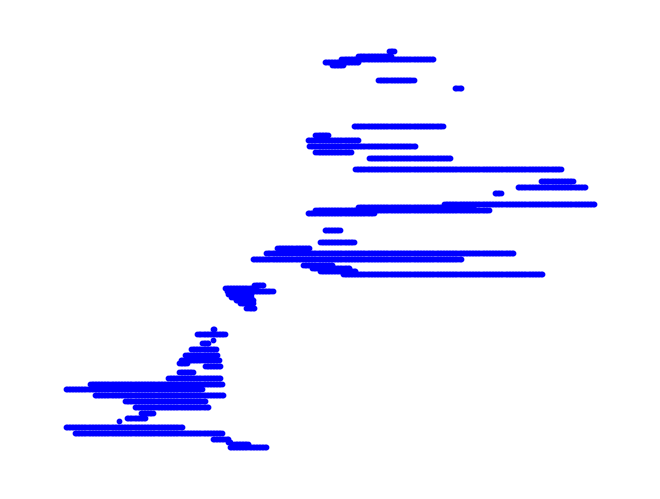

In [ ]:

def visualize_and_save_graph(G, file_name, dpi=300):
    # Set the size of the figure
    ax.set_aspect('equal')
    fig.set_size_inches(15, 15)
    plt.show()
    
    # Extract node positions from the graph G
    pos = {node: (node[0], node[1]) for node in G.nodes()}
    
    # Draw the network
    nx.draw(G, pos, node_size=10, width=1, with_labels=False, node_color='blue', edge_color='gray')
    
    plt.show()
    # Save the figure
    # plt.savefig(file_name, format='png', dpi=dpi, bbox_inches='tight')
    # plt.close()  # Close the figure to free memory

# Example usage:
visualize_and_save_graph(G, 'Data/Map_details/track_network.png', dpi=300)
